In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np


import torch.nn.functional as F

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()

        # self.curr_stack = nn.Sequential(
        #     nn.Linear(28*28, 28*28 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2, 28*28 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2, 28*28 // 2 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2 // 2, 28*28 // 2 // 2 // 2 // 2),
        #     nn.ReLU(),
        #     nn.Linear(28*28 // 2 // 2 // 2 // 2, 10),
        #     nn.LogSoftmax(dim=1)
        # )

       
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=6, kernel_size = 5)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*4*4, out_features= 120)
        self.fc2 = nn.Linear(in_features = 120, out_features = 60)
        self.out = nn.Linear(in_features= 60, out_features = 10)

    def forward(self, tensor):
        
        # hidden layer 1
        tensor = self.conv1(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride= 2)
        
        # hidden layer 2
        
        tensor = self.conv2(tensor)
        tensor = F.relu(tensor)
        tensor = F.max_pool2d(tensor, kernel_size = 2, stride = 2)
        
        #hidden layer 3
        
        tensor = tensor.reshape(-1, 12 * 4* 4)
        tensor = self.fc1(tensor)
        tensor = F.relu(tensor)
        
        #hidden layer 4
        
        tensor = self.fc2(tensor)
        tensor = F.relu(tensor)
        
        #output layer
        
        tensor = self.out(tensor)
        
        return tensor

In [9]:
def calculate_metrics(loader: DataLoader, model: nn.Module):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


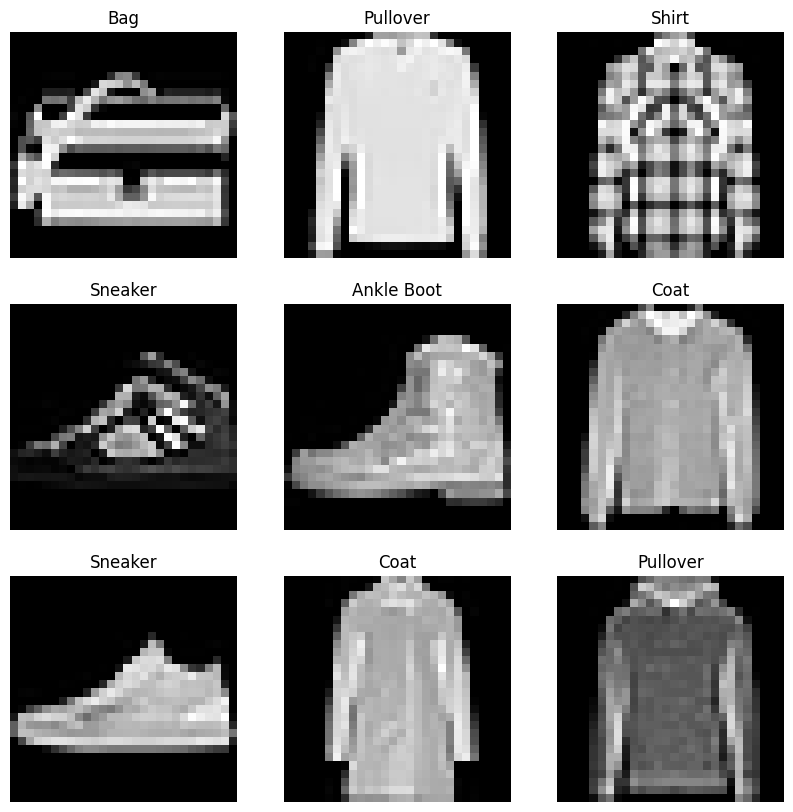

In [11]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(trainset), size = (1,)).item()
    image, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [12]:
net = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3)

val_acc, val_rec, val_prec, val_f1 =0,0,0,0
epoch = 0


while val_acc < 0.95 and val_rec < 0.95 and val_prec < 0.95 and val_f1 < 0.95:
    
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss:nn.CrossEntropyLoss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

    train_acc, train_rec, train_prec, train_f1 = calculate_metrics(trainloader, net)
    print(f'Training - Accuracy: {train_acc}, Recall: {train_rec}, Precision: {train_prec}, F1 Score: {train_f1}')

    val_acc, val_rec, val_prec, val_f1 = calculate_metrics(valloader, net)
    print(f'Validation - Accuracy: {val_acc}, Recall: {val_rec}, Precision: {val_prec}, F1 Score: {val_f1}')

    epoch+=1

print('Finished Training')

Epoch 1, Loss: 2.297


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.22751666666666667, Recall: 0.22751666666666667, Precision: 0.1604339307825518, F1 Score: 0.11204561539984656


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2267, Recall: 0.22670000000000004, Precision: 0.1486826981161728, F1 Score: 0.11187433907824185
Epoch 2, Loss: 2.273


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.3211333333333333, Recall: 0.3211333333333334, Precision: 0.27033758764857685, F1 Score: 0.23457057620074595


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.3197, Recall: 0.3197, Precision: 0.2599197882049602, F1 Score: 0.2345482266821184
Epoch 3, Loss: 2.232


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.25416666666666665, Recall: 0.25416666666666665, Precision: 0.2033071027436971, F1 Score: 0.1569369873474869


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2498, Recall: 0.24980000000000002, Precision: 0.20512742826964342, F1 Score: 0.1541422858174968
Epoch 4, Loss: 2.119


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.2609, Recall: 0.2609, Precision: 0.1756276718792439, F1 Score: 0.1415054246735344


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2628, Recall: 0.26280000000000003, Precision: 0.17175418168275428, F1 Score: 0.1434793429634389
Epoch 5, Loss: 1.868


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training - Accuracy: 0.25585, Recall: 0.25585, Precision: 0.21564282305185004, F1 Score: 0.13457289058444827


/home/oleg/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation - Accuracy: 0.2579, Recall: 0.25789999999999996, Precision: 0.17633884489864787, F1 Score: 0.13525551314408746
Epoch 6, Loss: 1.648
Training - Accuracy: 0.3456, Recall: 0.3456, Precision: 0.39843689696482193, F1 Score: 0.2597523436536192
Validation - Accuracy: 0.3482, Recall: 0.34819999999999995, Precision: 0.3893033488183007, F1 Score: 0.26136818382395044
Epoch 7, Loss: 1.471
Training - Accuracy: 0.4888166666666667, Recall: 0.4888166666666667, Precision: 0.5297172013991454, F1 Score: 0.46142299436924156
Validation - Accuracy: 0.4935, Recall: 0.49349999999999994, Precision: 0.532649346313863, F1 Score: 0.4654513587282699
Epoch 8, Loss: 1.283
Training - Accuracy: 0.5673, Recall: 0.5672999999999999, Precision: 0.5662534811800738, F1 Score: 0.5553765143179741
Validation - Accuracy: 0.5659, Recall: 0.5659, Precision: 0.5647158571589224, F1 Score: 0.5543579946387863
Epoch 9, Loss: 1.104
Training - Accuracy: 0.61535, Recall: 0.6153500000000001, Precision: 0.6069202674830388, F1 Sc